In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
"""
RAM-lean DBSCAN Fraud Detection (IEEE-CIS)
- Subsampled training
- Float32 downcast
- Drop ultra-sparse columns
- PCA on subset
- Predict by distance to DBSCAN core samples

Requires: numpy, pandas, scikit-learn
"""

import os, gc, warnings, numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, auc as sk_auc

warnings.filterwarnings("ignore")

# ---------------- Config (tune these if RAM is tight) ----------------
RANDOM_STATE        = 42
TEST_SIZE           = 0.2
MAX_TRAIN_SAMPLES   = 150_000     # reduce to 75_000 or 50_000 if needed
PCA_COMPONENTS      = 20          # 10–30 is usually fine
MISSING_DROP_THRESH = 0.90        # drop cols with >90% missing
MIN_SAMPLES_GRID    = [15, 30]
PERCENTILES_GRID    = [95, 97.5, 99]  # for eps from k-distance
K_FOR_KDIST         = 30          # usually ~= min_samples
DATA_DIR            = "/kaggle/input/ieee-fraud-detection"
TXN_FILE, ID_FILE   = "train_transaction.csv", "train_identity.csv"

# ---------------- Utils ----------------
def load_df():
    tx = pd.read_csv(os.path.join(DATA_DIR, TXN_FILE), index_col="TransactionID")
    idf = pd.read_csv(os.path.join(DATA_DIR, ID_FILE), index_col="TransactionID")
    df = tx.join(idf, how="left")
    if "TransactionDT" in df.columns:
        df = df.sort_values("TransactionDT")
    if "isFraud" not in df.columns:
        raise KeyError("Missing 'isFraud'")
    return df

def drop_sparse_and_keep_numeric(df):
    # Drop columns too sparse (saves RAM immediately)
    miss_frac = df.isna().mean()
    keep_cols = miss_frac[miss_frac <= MISSING_DROP_THRESH].index
    df = df[keep_cols]
    # Keep numeric only for DBSCAN
    y = df["isFraud"].astype(np.int8)
    X = df.drop(columns=["isFraud"]).select_dtypes(include=[np.number])
    # Downcast to float32/int32
    for c in X.columns:
        if pd.api.types.is_float_dtype(X[c]):
            X[c] = X[c].astype(np.float32)
        elif pd.api.types.is_integer_dtype(X[c]):
            # small ints are fine; cast to int32
            X[c] = X[c].astype(np.int32)
    return X, y

def chrono_split(X, y, test_size=TEST_SIZE):
    n = len(X)
    split = int((1 - test_size) * n)
    return X.iloc[:split], X.iloc[split:], y.iloc[:split], y.iloc[split:]

def stratified_subset(Xtr, ytr, max_samples=MAX_TRAIN_SAMPLES, random_state=RANDOM_STATE):
    """Keep ALL frauds + random nonfrauds to cap total size."""
    fraud_idx = ytr[ytr == 1].index
    non_idx   = ytr[ytr == 0].index
    keep_f = fraud_idx
    remaining = max_samples - len(keep_f)
    if remaining <= 0:
        # if extreme: just use all frauds (rare) and sample some of them
        keep_f = np.random.RandomState(random_state).choice(fraud_idx, size=max_samples, replace=False)
        keep = np.array(keep_f)
    else:
        rng = np.random.RandomState(random_state)
        take_non = min(remaining, len(non_idx))
        keep_non = rng.choice(non_idx, size=take_non, replace=False)
        keep = np.concatenate([keep_f, keep_non])
    keep = pd.Index(keep)
    Xsub, ysub = Xtr.loc[keep].copy(), ytr.loc[keep].copy()
    return Xsub, ysub

def fit_scaler_pca(Xref, n_components=PCA_COMPONENTS):
    med = Xref.median()          # robust + cheap
    Xf  = Xref.fillna(med)
    scaler = StandardScaler()
    Xs = scaler.fit_transform(Xf)
    n_comp = min(n_components, Xs.shape[1])
    pca = PCA(n_components=n_comp, svd_solver="randomized", random_state=RANDOM_STATE)
    Xp = pca.fit_transform(Xs).astype(np.float32)
    return med, scaler, pca, Xp

def transform_with(med, scaler, pca, X):
    Xf = X.fillna(med)
    Xs = scaler.transform(Xf)
    return pca.transform(Xs).astype(np.float32)

def kdistances(X, k=K_FOR_KDIST):
    # Use Ball Tree to keep memory down
    nn = NearestNeighbors(n_neighbors=k, algorithm="ball_tree", n_jobs=-1)
    nn.fit(X)
    dists, _ = nn.kneighbors(X)
    return dists[:, -1].astype(np.float32)

def fit_dbscan(X, eps, min_samples):
    # 'ball_tree' helps in mid/high dims better than kd_tree
    return DBSCAN(eps=eps, min_samples=min_samples, algorithm="ball_tree", n_jobs=-1).fit(X)

def core_nn(db, X_fit):
    core_idx = db.core_sample_indices_
    if core_idx is None or len(core_idx) == 0:
        return None, None
    core_pts = X_fit[core_idx]
    nn = NearestNeighbors(n_neighbors=1, algorithm="ball_tree", n_jobs=-1).fit(core_pts)
    return nn, core_pts

def predict_scores(nn_core, eps, X_new):
    if nn_core is None:
        # No cores -> everything anomalous (fallback)
        return np.ones(len(X_new), dtype=np.int8), np.ones(len(X_new), dtype=np.float32)
    d, _ = nn_core.kneighbors(X_new, n_neighbors=1)
    d = d.ravel().astype(np.float32)
    yhat = (d > eps).astype(np.int8)   # > eps => outside density -> "fraud"
    return yhat, d

# ---------------- Main ----------------
if __name__ == "__main__":
    df = load_df()
    print(f"Merged: {df.shape}")

    # Keep numeric, drop ultra-sparse, downcast
    X, y = drop_sparse_and_keep_numeric(df)
    del df; gc.collect()
    print(f"After filtering -> X: {X.shape}, y: {y.shape} | numeric cols={X.shape[1]}")

    # Chronological split (avoids leakage)
    Xtr, Xte, ytr, yte = chrono_split(X, y)
    del X, y; gc.collect()
    print(f"Train: {Xtr.shape}, Test: {Xte.shape}, Frauds in train: {ytr.sum()}")

    # Subsample train to fit transforms + DBSCAN
    Xsub, ysub = stratified_subset(Xtr, ytr, MAX_TRAIN_SAMPLES)
    print(f"Subset for fitting: {Xsub.shape} (kept all frauds: {ysub.sum()})")

    # Fit scaler + PCA on subset (RAM-friendly), no need to transform full train
    med, scaler, pca, Xsub_pca = fit_scaler_pca(Xsub, PCA_COMPONENTS)
    print(f"PCA dims: {Xsub_pca.shape[1]}")

    # Choose eps from k-distance percentiles on subset
    kd = kdistances(Xsub_pca, k=K_FOR_KDIST)
    best = {"ap": -np.inf, "eps": None, "min_samples": None}
    for ms in MIN_SAMPLES_GRID:
        for p in PERCENTILES_GRID:
            eps = np.percentile(kd, p).item()
            db  = fit_dbscan(Xsub_pca, eps=eps, min_samples=ms)
            nnc, _ = core_nn(db, Xsub_pca)
            # Use subset as a quick proxy for AP (unsupervised; labels only to guide tuning)
            _, scores = predict_scores(nnc, eps, Xsub_pca)
            ap = average_precision_score(ysub, scores)
            if ap > best["ap"]:
                best.update({"ap": ap, "eps": eps, "min_samples": ms})
    eps_opt, ms_opt = best["eps"], best["min_samples"]
    print(f"Chosen: eps={eps_opt:.5f}, min_samples={ms_opt} (subset AP={best['ap']:.5f})")

    # Fit final DBSCAN on subset
    db  = fit_dbscan(Xsub_pca, eps=eps_opt, min_samples=ms_opt)
    nnc, core_pts = core_nn(db, Xsub_pca)

    # Transform ONLY the test set and score
    Xte_pca = transform_with(med, scaler, pca, Xte)
    yhat, scores = predict_scores(nnc, eps_opt, Xte_pca)

    # Metrics (scores: higher = more anomalous)
    roc  = roc_auc_score(yte, scores)
    ap   = average_precision_score(yte, scores)
    prec, rec, _ = precision_recall_curve(yte, scores)
    pr_auc = sk_auc(rec, prec)

    print("\n=== DBSCAN (RAM-lean) Test Metrics ===")
    print(f"ROC-AUC: {roc:.5f}")
    print(f"Average Precision (AP): {ap:.5f}")
    print(f"PR-AUC: {pr_auc:.5f}")
    print(f"Predicted frauds (noise): {int(yhat.sum())} / {len(yhat)}")

    # Save outputs (optional)
    out = pd.DataFrame({"score": scores, "pred_fraud": yhat, "isFraud": yte.values}, index=Xte.index)
    out.to_csv("dbscan_ram_lean_predictions.csv")
    print("Saved: dbscan_ram_lean_predictions.csv")

    # Cleanup
    del Xtr, Xte, ytr, yte, Xsub, ysub, Xsub_pca, Xte_pca, kd, scores, yhat
    gc.collect()


Merged: (590540, 433)
After filtering -> X: (590540, 391), y: (590540,) | numeric cols=391
Train: (472432, 391), Test: (118108, 391), Frauds in train: 16599
Subset for fitting: (150000, 391) (kept all frauds: 16599)
PCA dims: 20
Chosen: eps=7.44825, min_samples=30 (subset AP=0.19669)

=== DBSCAN (RAM-lean) Test Metrics ===
ROC-AUC: 0.72272
Average Precision (AP): 0.09268
PR-AUC: 0.09263
Predicted frauds (noise): 4104 / 118108
Saved: dbscan_ram_lean_predictions.csv


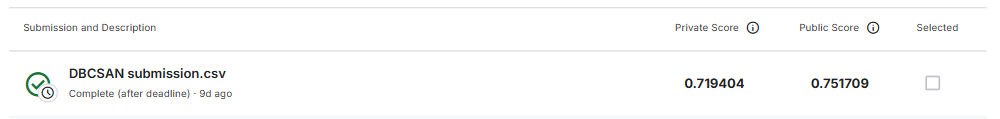